In [40]:
import torch
import a6
import pathlib
import numpy as np
import matplotlib.pyplot as plt


path = pathlib.Path("/p/scratch/deepacf/emmerich1/dcv2/multi-level-all-fields-1964-2023/results/tensors")

In [34]:
def get_epoch_from_file_name(p: pathlib.Path) -> int:
    return int(p.name.split("-")[1])

def sort_by_epoch(paths: list[pathlib.Path]) -> list[pathlib.Path]:
    return sorted(paths, key=lambda p: get_epoch_from_file_name(p))

distance_files = sort_by_epoch(path.glob("*-distances.pt"))
embeddings_files = sort_by_epoch(path.glob("*-embeddings.pt"))
centroids_files = sort_by_epoch(path.glob("*-centroids.pt"))

device = torch.device('cpu')

distances = [torch.load(file, map_location=device) for file in distance_files]
embeddings = [torch.load(file, map_location=device) for file in embeddings_files]
centroids = [torch.load(file, map_location=device) for file in centroids_files]

In [35]:
epochs = [get_epoch_from_file_name(file) for file in centroids_files]
epochs

[0, 24, 49, 74, 99, 199, 299, 399, 499, 599, 699, 799]

In [8]:
# embeddings has shape (N_heads, N_crops, N_samples, N_dim)
dot_products = torch.mm(embeddings[0][0][0], centroids[0].t())
local_distances, local_assignments = dot_products.max(dim=1)

In [12]:
local_assignments

tensor([17, 10, 28,  ..., 17,  3, 24])

In [51]:
# N_heads is 3
def calculate_ssd(d: torch.Tensor) -> float:
    return (d.abs() ** 2).sum()

ssd_per_head = [(d.abs() ** 2).sum(dim=1) for d in distances]
ssd_mean = [ssd.mean() for ssd in ssd_per_head]
ssd_std = [ssd.std() for ssd in ssd_per_head]

<ErrorbarContainer object of 3 artists>

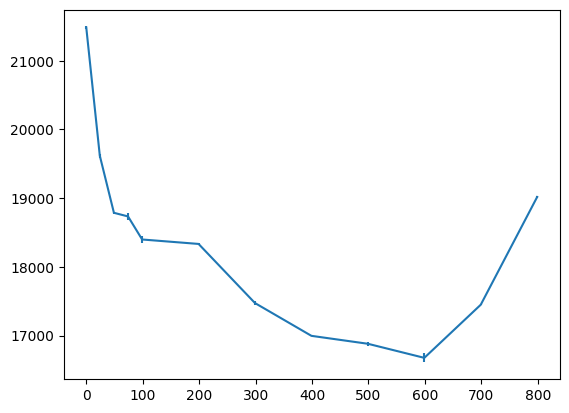

In [54]:
plt.figure()
plt.errorbar(epochs, ssd_mean, ssd_std)